# Cuaderno 26: Modelo para el TSP con desigualdades de corte

$\newcommand{\card}[1]{\left| #1 \right|}$
$\newcommand{\tabulatedset}[1]{\left\{ #1 \right\}}$
$\newcommand{\ZZ}{\mathbb{Z}}$
$\newcommand{\RR}{\mathbb{R}}$

Dados: 
* un grafo no dirigido **completo** $G=(V,E)$; y,
* un vector $c \in \ZZ^{E}$ de costos asociados a las aristas de $G$.

El *problema del agente viajero (Traveling Salesman Problem, TSP)* consiste en encontrar un ciclo que visite **todos** los nodos de $G$ y que tenga el menor costo posible.

Al tratarse de una versión no dirigida del problema, las restricciones de grado entrante y saliente se reemplazan por una única restricción de grado para cada nodo: cada nodo debe ser incidente a dos aristas del tour.

Por otra parte, notar que para impedir subciclos en una solución es suficiente con requerir que la misma sea conexa,
lo cual puede hacerse a través de desigualdades de corte, similares al caso del árbol generador de peso mínimo. En el TSP, estas desigualdades pueden ser mejoradas al observar que, para cualquier conjunto $W \subset V$ con $\emptyset \neq W \neq V$, todo tour factible debe contener al menos *dos* aristas del corte $\delta(W)$.

Utilizando variables binarias $x_{ij}$ para indicar la selección de aristas, el problema del agente viajero puede formularse como el siguiente programa lineal entero:

\begin{align*}
\min &\sum_{ij \in E} c_{ij} x_{ij}\\ 
& \mbox{s.r.}\\
&\sum_{ij \in \delta(i) } x_{ij} = 2, \quad \forall i \in V,\\
&\sum_{ij \in \delta(W)} x_{ij} \geq 2, \quad \forall W \subset V, \emptyset \neq W \neq V,\\
& x_{ij} \in \{0, 1\}, \quad \forall ij \in E,
\end{align*}
donde $\delta(W) := \{ ij \in E \, : \, i \in W, j \not\in W\}$.

Vamos a implementar este modelo usando la interfaz Python de Gurobi.



Definimos primero los datos. Usaremos la función `randint` del módulo random para generar valores aleatorios en el rango {0,..,100} para las coordenadas de cada nodo. Los costos de las aristas serán iguales a las distancias euclideanas entre sus nodos extremos. Notar que el diccionario `c` contiene cada arista una sola vez, debido a la condición `if i < j`.

In [1]:
from gurobipy import *
import random as rm
import math 

# Numero de nodos del grafo
n = 10

# Nodos del grafo
V = tuplelist(range(1,n+1))

# Posiciones de los nodos en un plano euclideano entre (0,0) y (100, 100)
coordx={i : rm.randint(0,100) for i in V}
coordy={i : rm.randint(0,100) for i in V}

# los costos son las distancias eculideanas
c = tupledict({(i,j) : math.sqrt((coordx[i] - coordx[j])**2 + (coordy[i] - coordy[j])**2)
              for i in V for j in V if i < j})
 
E = c.keys()


Vamos a necesitar construir una restricción de corte para cada subconjunto de nodos $W \subset V$ tal que $\emptyset \neq W \neq V$. Con esta finalidad, definimos una función `powerset` empleando las funciones `chain` y `combinations` del módulo `itertools`.

In [2]:
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))


Emplearemos el módulo `matplotlib` para graficar el tour de la solución. Definiremos para ello la función `dibujarTour` que recibe tres argumentos: una lista `coordx` con las coordenadas horizontales de los nodos, una lista `coordy` con las coordenadas verticales y un vector `tour` con una permutación de los nodos indicando el orden de visita en la solución.

In [3]:
import matplotlib.pyplot as plt
import random

def dibujarTour(coordx, coordy, tour):
    x = [coordx[i] for i in tour]
    y = [coordy[i] for i in tour]
    plt.plot(x, y, 'ro')
    Tx = [coordx[i] for i in tour]
    Ty = [coordy[i] for i in tour]
    Tx.append(coordx[tour[0]])
    Ty.append(coordy[tour[0]])
    plt.plot(Tx, Ty, 'b-')
    plt.show()

Definimos ahora el objeto modelo, las variables y la función objetivo:

In [4]:
# Crear el objeto modelo
m = Model('tsp-corte')

# Crear las variables
x = m.addVars(E, name="x", vtype=GRB.BINARY)

# Crear la funcion objetivo
m.setObjective(x.prod(c,'*'), GRB.MINIMIZE)


Using license file /Users/ltorres/gurobi.lic
Academic license - for non-commercial use only


Añadimos las restricciones de grado. Observar que son necesarias **dos sumas** en cada restricción para cubrir todas las aristas del corte $\delta(i)$: 

In [5]:
# Restricciones de grado
m.addConstrs((x.sum(i,'*') + x.sum('*', i) == 2 for i in V), 
                 "grado")

{1: <gurobi.Constr *Awaiting Model Update*>,
 2: <gurobi.Constr *Awaiting Model Update*>,
 3: <gurobi.Constr *Awaiting Model Update*>,
 4: <gurobi.Constr *Awaiting Model Update*>,
 5: <gurobi.Constr *Awaiting Model Update*>,
 6: <gurobi.Constr *Awaiting Model Update*>,
 7: <gurobi.Constr *Awaiting Model Update*>,
 8: <gurobi.Constr *Awaiting Model Update*>,
 9: <gurobi.Constr *Awaiting Model Update*>,
 10: <gurobi.Constr *Awaiting Model Update*>}

Para construir las restricciones de corte, usamos la función `powerset` para iterar sobre todos los subconjuntos de nodos $W$ tales que $\emptyset \neq W \neq V$. Para cada subconjunto, se construye primero el conjunto `Wc` con su 
complemento, es decir, con los nodos de $V$ que no están en $W$. La expresión `x.sum(W, Wc)` construye la suma de las variables asociadas a aristas que tienen el "primer" extremo en $W$ y el otro extremo fuera de $W$. De manera similar, `x.sum(Wc, W)` construye la suma de las variables asociadas a aristas que tienen el "primer" extremo fuera de $W$ y el otro extremo en $W$. La suma de ambas expresiones es igual a la suma de todas las aristas del corte.

In [6]:
# Restricciones de corte
PV = list(powerset(V))
for W in PV:
    if W!=() and W!=tuple(V):
        Wc = [i for i in V if i not in W]
        m.addConstr(x.sum(W, Wc) + x.sum(Wc, W) >= 2, 
                        "corte[{}]".format(W))


Escribimos el modelo a un archivo de texto:

In [7]:
# Escribir el modelo a un archivo
m.write('tsp-corte.lp')


Finalmente, resolvemos el modelo y mostramos la solución:

In [8]:
# Calcular la solucion optima
m.optimize()

# Escribir la solucion
if m.status == GRB.Status.OPTIMAL:
    # Recuperar los valores de las variables
    vx = m.getAttr('x', x)
    print('\nTour optimo:')
    for i,j in E:
        if vx[i,j] >= 0.9:
            print('{} -- {}'.format(i, j))


Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 1032 rows, 45 columns and 23130 nonzeros
Model fingerprint: 0x5ca9d7a9
Variable types: 0 continuous, 45 integer (45 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [3e+00, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective 635.2680724
Presolve removed 521 rows and 0 columns
Presolve time: 0.11s
Presolved: 511 rows, 45 columns, 11520 nonzeros
Variable types: 0 continuous, 45 integer (45 binary)

Root relaxation: objective 3.201380e+02, 18 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     320.1380145  320.13801  0.00%     -    0s

Explored 0 nodes (18 simplex iterations) in 0.29 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 320.138 

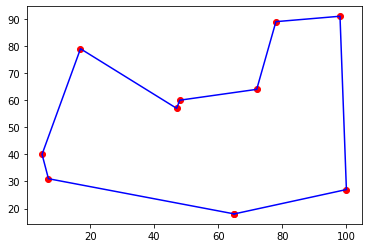

In [9]:
# Crear lista con arcos seleccionados en la solucion
L = [(i,j) for i,j in E if vx[i,j]>0]

# Recuperar el tour como un ordenamiento de los nodos
T = [1]
# nodo actual:
i = 1
while True:
    # Determinar sucesor de i
    N = [j for j in V if (i,j) in L] + [j for j in V if (j,i) in L] 
    j = N.pop()
    a = (i,j) if (i,j) in L else (j,i)
    L.remove(a)
    # Colocar sucesor en la lista del tour y actualizar i
    T.append(j)
    i = j
    # Terminar cuando el nodo colocado sea 1
    if i==1: break;
        
# Graficar el tour
dibujarTour(coordx, coordy, T)    

## Código completo

Se reproduce a continuación el código completo del modelo anterior.

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 1032 rows, 45 columns and 23130 nonzeros
Model fingerprint: 0x905542c4
Variable types: 0 continuous, 45 integer (45 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+01, 1e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Found heuristic solution: objective 413.1578879
Presolve removed 521 rows and 0 columns
Presolve time: 0.06s
Presolved: 511 rows, 45 columns, 11520 nonzeros
Variable types: 0 continuous, 45 integer (45 binary)

Root relaxation: objective 2.311489e+02, 15 iterations, 0.01 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0     231.1488505  231.14885  0.00%     -    0s

Explored 0 nodes (15 simplex iterations) in 0.15 seconds
Thread count was 4 (of 4 available processors)

Solution count 2: 231.149 

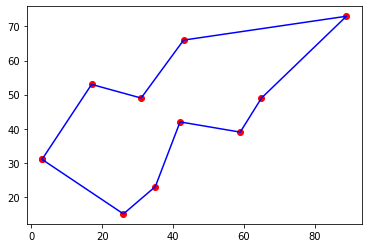

In [12]:
# Implementación de modelos lineales enteros
# Problema del agente viajero (TSP)

# Luis M. Torres (EPN 2020)

from gurobipy import *
import random as rm
import matplotlib.pyplot as plt
from itertools import chain, combinations

def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

def dibujarTour(coordx, coordy, tour):
    x = [coordx[i] for i in tour]
    y = [coordy[i] for i in tour]
    plt.plot(x, y, 'ro')
    Tx = [coordx[i] for i in tour]
    Ty = [coordy[i] for i in tour]
    Tx.append(coordx[tour[0]])
    Ty.append(coordy[tour[0]])
    plt.plot(Tx, Ty, 'b-')
    plt.show()

# Numero de nodos del grafo
n = 10

# Nodos del grafo
V = tuplelist(range(1,n+1))

# Posiciones de los nodos en un plano euclideano entre (0,0) y (100, 100)
coordx={i : rm.randint(0,100) for i in V}
coordy={i : rm.randint(0,100) for i in V}

# los costos son las distancias eculideanas
c = tupledict({(i,j) : math.sqrt((coordx[i] - coordx[j])**2 + (coordy[i] - coordy[j])**2)
              for i in V for j in V if i < j})
 
E = c.keys()

try:
    # Crear el objeto modelo
    m = Model('tsp-corte')

    # Crear las variables
    x = m.addVars(E, name="x", vtype=GRB.BINARY)

    # Crear la funcion objetivo
    m.setObjective(x.prod(c,'*'), GRB.MINIMIZE)

    # Restricciones de grado
    m.addConstrs((x.sum(i,'*') + x.sum('*', i) == 2 for i in V), 
                 "grado")

    # Restricciones de corte
    PV = list(powerset(V))
    for W in PV:
        if W!=() and W!=tuple(V):
            Wc = [i for i in V if i not in W]
            m.addConstr(x.sum(W, Wc) + x.sum(Wc, W) >= 1, 
                            "corte[{}]".format(W))

    # Escribir el modelo a un archivo
    # m.write('tsp-corte.lp')

    # Calcular la solucion optima
    m.optimize()

    # Escribir la solucion
    if m.status == GRB.Status.OPTIMAL:
        # Recuperar los valores de las variables
        vx = m.getAttr('x', x)
        print('\nTour optimo:')
        for i,j in E:
            if vx[i,j] >= 0.9:
                print('{} -> {}'.format(i, j))
                
    # Crear lista con arcos seleccionados en la solucion
    L = [(i,j) for i,j in E if vx[i,j]>0]

    # Recuperar el tour como un ordenamiento de los nodos
    T = [1]
    # nodo actual:
    i = 1
    while True:
        # Determinar sucesor de i
        N = [j for j in V if (i,j) in L] + [j for j in V if (j,i) in L] 
        j = N.pop()
        a = (i,j) if (i,j) in L else (j,i)
        L.remove(a)
        # Colocar sucesor en la lista del tour y actualizar i
        T.append(j)
        i = j
        # Terminar cuando el nodo colocado sea 1
        if i==1: break;
        
    # Graficar el tour
    dibujarTour(coordx, coordy, T)    
    
except GurobiError as e:
    print('Se produjo un error de Gurobi: codigo: ' + str(e.errno) + ": " + str(e))

except AttributeError:
    print('Se produjo un error de atributo')